In [7]:
import numpy as np
import cv2

from scipy.io import loadmat

import numpy as np
import matplotlib.pyplot as plt 

from sklearn.mixture import GaussianMixture

# Loading Data

In [8]:
path = '/Users/jackmango/Desktop/QUIRP - Work/Princeton/Data/06:23:23/imaging exposure time = 30ms/'
filename = 'camera,fIdx=3354844,bx0_V=-0.068000000,by0_V=-0.230000000,bz0_V=0.020000000,imagingDetuning0_MHz=-0.600000000,cameraExposureTime=0.030000000,iterator=24.000000000.mat'
data = loadmat(path + filename)
n_loops = 20
stack = data['stack']

In [9]:
def fractional_stack(stack, n_loops, n):
    # Given the stack and an integer n, slice the first 1 / n images from the stack and return the averaged images across this set
    per_loop = stack.shape[0] // n_loops
    slices = np.empty((n_loops, *stack.shape[1:]))
    for i in range(n_loops):
        slice_size = per_loop // n
        slices[i] = np.mean(stack[i * per_loop: i * per_loop + slice_size], axis=0)
    return slices

def find_positions(stack, n_tweezers, n_loops, keep_borders=False):
    frac_stack = fractional_stack(stack, n_loops, 8)
    final = np.zeros(frac_stack.shape[1:], dtype='uint8')
    for img in frac_stack:
        img = np.copy(img).astype('uint8')
        img = cv2.GaussianBlur(img, (3, 3), 0)
        model = GaussianMixture(2)
        model.fit(np.reshape(img.flatten(), (img.size, 1)))
        std = np.sqrt(model.covariances_.flatten())
        thresh = -4 * np.maximum(std.min(), 0.6)
        img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 9, thresh)
        n_sites, labeled_img, stats, centroids = cv2.connectedComponentsWithStats(img)
        for stat in stats:
            if stat[-1] <= 2:
                img[stat[1]:stat[1] + stat[3], stat[0]:stat[0] + stat[2]] = np.zeros((stat[3], stat[2]))
        final = np.maximum(img, final)
    plt.imshow(final)
    n_sites, labeled_img, stats, centroids = cv2.connectedComponentsWithStats(final)
    centroids = centroids[np.argsort(stats[:,-1])]
    return centroids[-2:-n_tweezers - 2:-1]

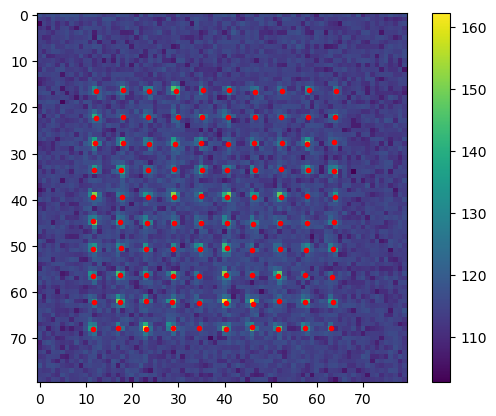

In [10]:
centroids = find_positions(stack, 100, 20)
plt.imshow(np.mean(stack, axis=0))
plt.plot(*centroids.T, 'r.')
plt.colorbar()
plt.show()